In [1]:
import numpy as np
from skimage.draw import circle, polygon
import tensorflow as tf

from batchflow import ImagesBatch, action, inbatch_parallel, any_action_failed
from batchflow import Dataset, best_practice, B, V, C, Pipeline
from batchflow.models.tf.losses import dice, softmax_cross_entropy

from batchflow.models.tf import UNet
from batchflow.research import Results
from src import show_samples, show_loss
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def loss(labels, logits, alpha=0.75, *args, **kwargs):

    bce_loss = alpha * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))
    dice_loss = (1-alpha) * dice(labels, logits, loss_collection=None)
    loss = bce_loss + dice_loss
    tf.losses.add_loss(loss)

    return loss

In [3]:
def creating_images(size, r_min, r_max):
        img = np.zeros((size, size, 3))
        loc = []
        vals = [255, 255]
        for f,v in zip(["c", "s"], vals):
            r = np.random.randint(r_min, r_max + 1)
            xc, yc = np.random.randint(r, size - r + 1, 2)
            if f == "c":
                 mask = circle(xc, yc, r, (size, size))
            if f == "s":
                 mask = polygon((xc - r, xc + r, xc + r, xc - r),
                            (yc - r, yc - r, yc + r, yc + r), (size, size))
            img[:, :, ["c", "s"].index(f)][mask] = v
        img[:, :, 2] = np.clip(img.sum(axis=-1, keepdims=True)[:,:,0], 1, 0)
        return img

In [4]:
class ShapesBatch(ImagesBatch):
    
    def __init__(self, index, preloaded=None):
        super().__init__(index, preloaded)
        

    @action
    @inbatch_parallel(init="indices", post="_assemble_batch")
    def sample_images(self, i, size, r_min=10, r_max=None):
        """Generate images with geometrical shapes.
        """
        if r_max is None:
            r_max = size // 2
        return creating_images(size, r_min, r_max)
    
    def _assemble_batch(self, results, *args, **kwargs):
        """Concatenate results of different workers.
        """
        _ = args, kwargs
        img = results
        img = np.stack(img)
        self.images = np.clip(img.sum(axis=-1, keepdims=True), 0, 255)
        self.masks = np.clip(img[:, :, :, :3], 0, 1).astype(int)
        return self

In [5]:
Images = Dataset(1000, ShapesBatch)

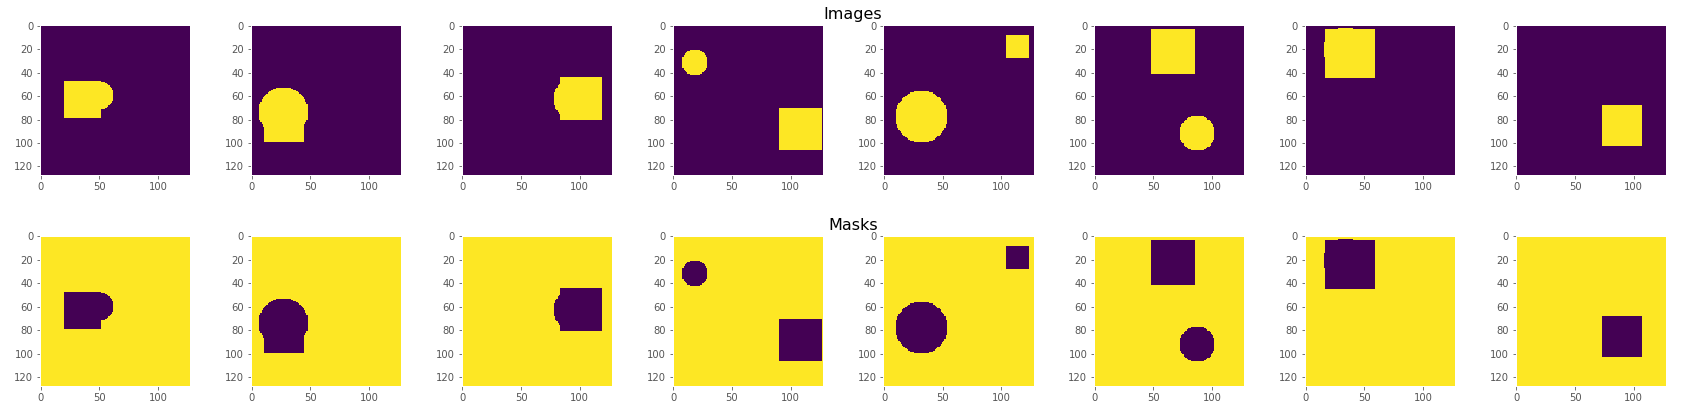

In [6]:
size = 8
batch = Images.next_batch(size).sample_images(128,  r_max=24)

show_samples([batch.images[:, :, :, 0], batch.masks[:, :, :, 2]], row_titles=["Images", "Masks"])

In [7]:
size = 128
model_config={'inputs': dict(images={'shape': B("image_shape")},
                             masks={'shape': [size, size, 3], 'name': 'targets'}),
              'initial_block/inputs': 'images',
              'body/filters': [12, 24, 48, 96],
              'head/num_classes': 3,
              'loss': loss,
              'optimizer': 'Adam',
              'output': 'labels'
             }

In [8]:
train_template = (Pipeline()
                  .init_variable('loss_history', init_on_each_run=list) 
                  .init_model('dynamic', UNet, 'unet', config=model_config)
                  .sample_images(size, r_max=24)
                  .train_model('unet', fetches='labels',
                               feed_dict={'images': B('images'),
                                          'masks': B('masks')},
                               save_to=V('loss_history'), mode='a'))

In [9]:
batch_size = 20

train_pipeline = (train_template << Images).run(batch_size, n_epochs=4, bar=True)

100%|███████████████████████████████████████▊| 199/200 [18:54<00:05,  5.66s/it]


In [10]:
predict_template = (Pipeline()
                    .import_model('unet', train_pipeline)
                    .init_variable("predictions", init_on_each_run=list)
                    .predict_model('unet', fetches='labels',
                                   feed_dict={'images': B('images')},
                                   save_to=V('predictions'), mode="e"))

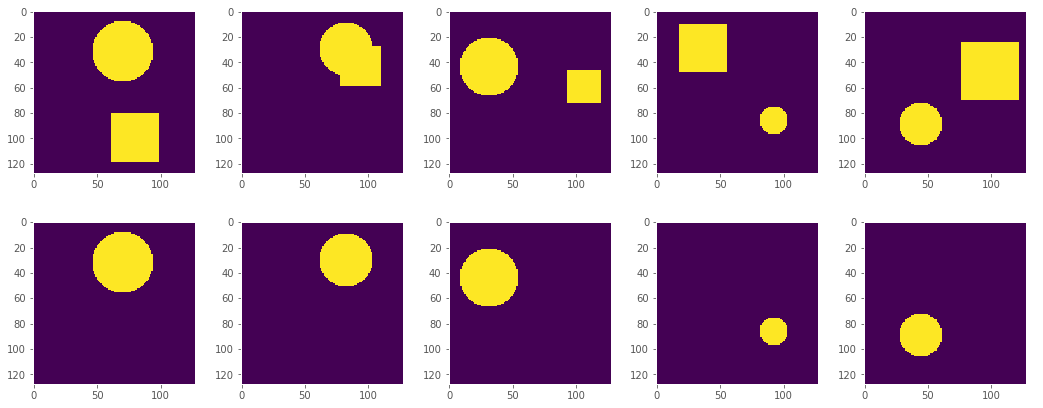

In [11]:
size_batch = 5
src_batch = Dataset(5, ShapesBatch).next_batch(5).sample_images(128, r_max=24)

show_samples([src_batch.images[:, :, :, 0], src_batch.masks[:, :, :, 0]])

In [12]:
predict_pipeline = ((predict_template << Dataset(5, ShapesBatch, preloaded=src_batch._data))
                    .run(20, shuffle=False, n_epochs=1, drop_last=False, bar=True))

  0%|                                                    | 0/1 [00:00<?, ?it/s]


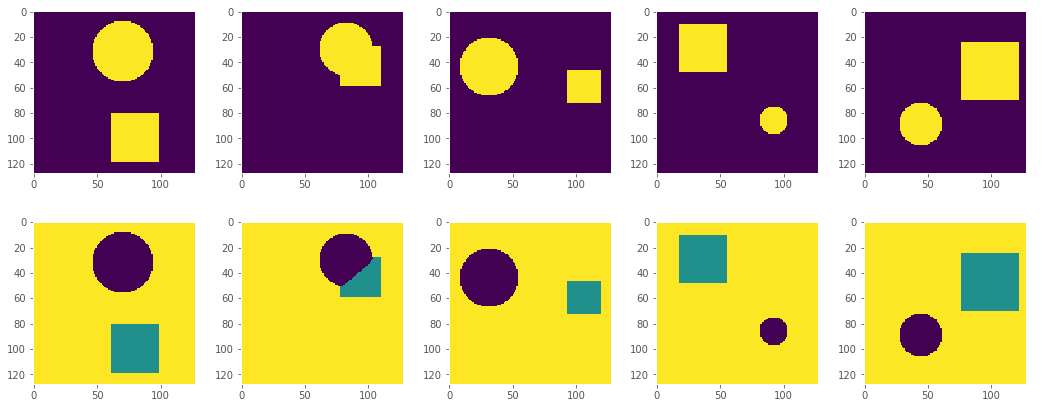

In [13]:
y_pred = np.rint(predict_pipeline.get_variable('predictions'))
show_samples([src_batch.images[:, :, :,0], y_pred[:, :]])